# Loading libraries

In [1]:
from typing import List, Union, Dict
import sys
import os
import yaml
import warnings
sys.path.insert(1, '..')
os.chdir('..')

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
import optuna
import darts

from darts import models
from darts import metrics
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

from data_formatter.base import *
from data_formatter.utils_darts import *

# Check statistics of the data

In [2]:
# load yaml config file
with open('./config/weinstock.yaml', 'r') as f:
    config = yaml.safe_load(f)

# set interpolation params for no interpolation
new_config = config.copy()
new_config['interpolation_params']['gap_threshold'] = 5
new_config['interpolation_params']['min_drop_length'] = 0
# set split params for no splitting
new_config['split_params']['test_percent_subjects'] = 0
new_config['split_params']['length_segment'] = 0
# set scaling params for no scaling
new_config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 0
	Extracted segments: 34060
Splitting data...
	Train: 647858 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


Train segment lengths:
	Min:  1
	Max:  1772
	1st Quartile:  1.0
	Median:  2.0
	Mean:  19.021080446271284
	Std:  54.361462006686246


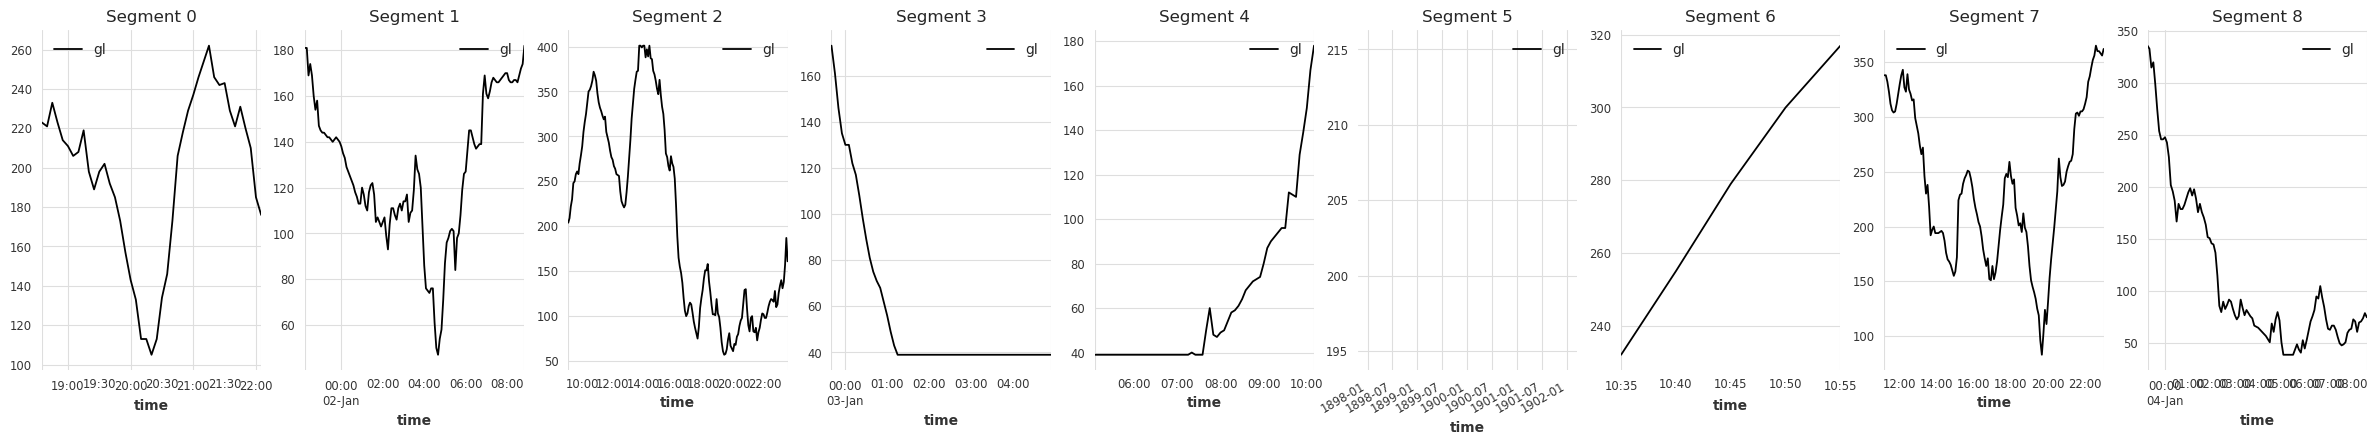

In [ ]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = len(formatter.train_data['id_segment'].unique()[0:9])
plot_data = formatter.train_data.loc[formatter.train_data['id_segment'].between(0,8)]

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))

50% of the segments length is less than 6 that is extremely low. Hence, the interpolation is strongly needed and some very short segments should be dropped as well.

First, use gap threshold as 45 minutes.

### Conduct interpolation

In [ ]:
# set interpolation params for interpolation
new_config['interpolation_params']['gap_threshold'] = 45 # minutes - use as in config file 

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 0
	Extracted segments: 12955
Splitting data...
	Train: 683524 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


Train segment lengths:
	Min:  1
	Max:  1991
	1st Quartile:  1.0
	Median:  1.0
	3rd Quartile:  1.0
	Mean:  52.76140486298726
	Std:  204.16096779769248


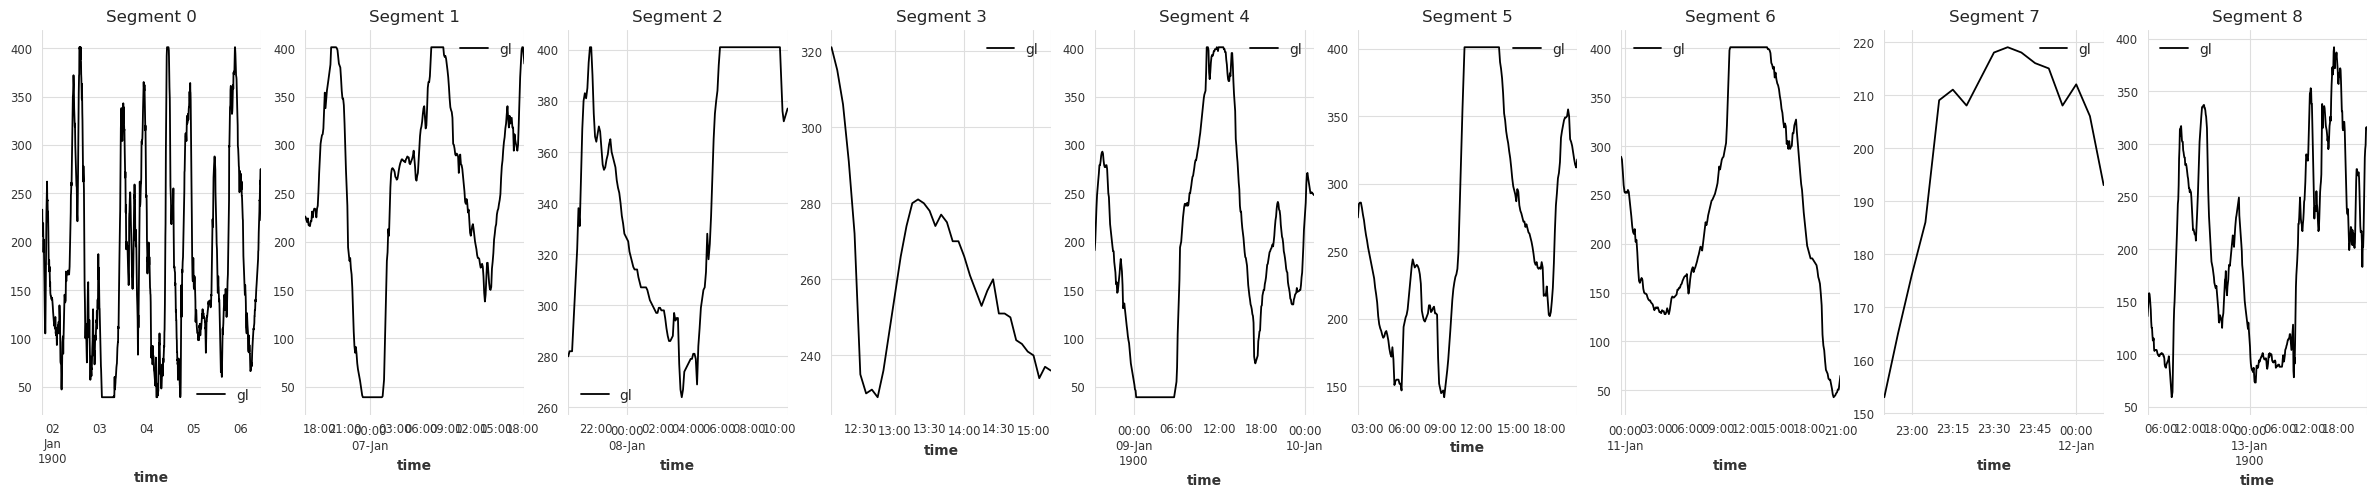

In [ ]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\t3rd Quartile: ', np.quantile(segment_lens, 0.75))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 9 segments
num_segments = len(formatter.train_data['id_segment'].unique()[0:9])
plot_data = formatter.train_data.loc[formatter.train_data['id_segment'].between(0,8)]

fig, axs = plt.subplots(1, num_segments, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data.plot(x='time', y='gl', ax=axs[i], title='Segment {}'.format(group))

Interpolatolation helped partially, but 25% of the segments are still too short - their length is less than 25 measurements, and half of the segments - less than 120. The range of the segments length is too big. There is more than three times difference between median and third quartile values.

Segment 2 is too short
Segment 3 is too short
Segment 5 is too short
Segment 6 is too short
Segment 7 is too short


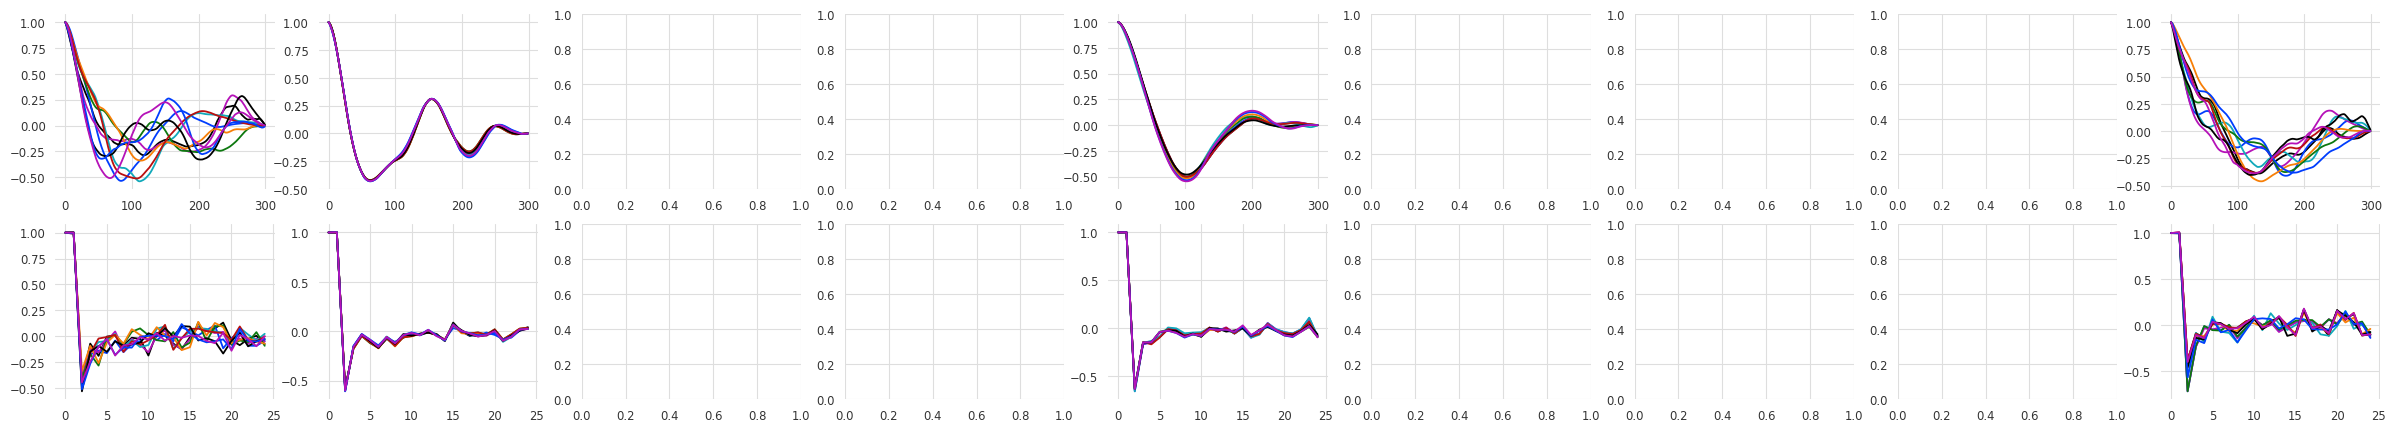

In [ ]:
# plot acf of random samples from first 9 segments segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    # select 10 random samples from index of data
    sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
    # plot acf / pacf of each sample
    for j in sample:
        acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
        pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
        ax[0, i].plot(acf)
        ax[1, i].plot(pacf)

Based on the ACF & PACF plots from the above we can probably distinguish segments that were affected by interpolation - their ACF and PACF plots are much more smooth and have almost no variance between samples from index of data. 

To get the right idea about which threshold to put on the segments length to drop, more ACF & PACF plots should be analyzed. Below are the plots for nine segments with the biggest length. 

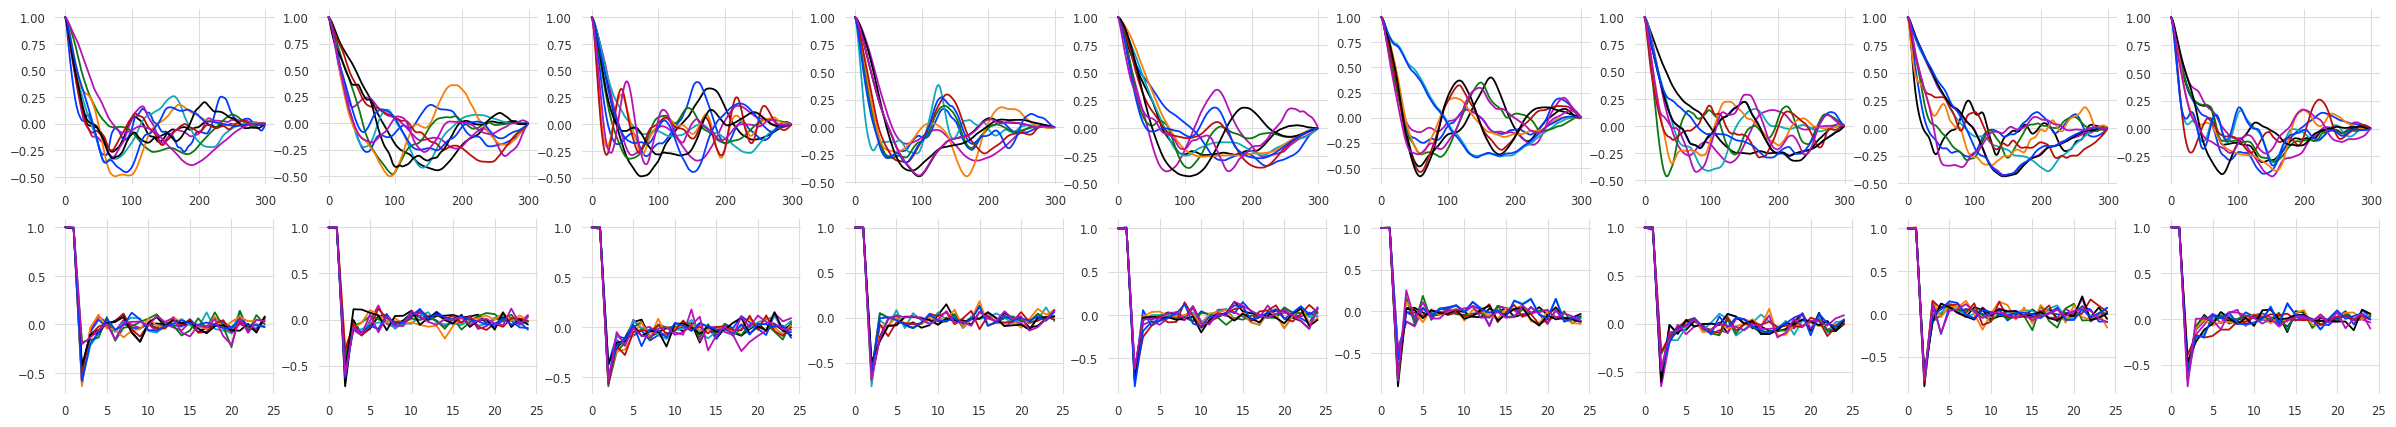

In [ ]:
# get ids of the nine segments with biggest length
inx = np.array(formatter.train_data.groupby('id_segment').size().sort_values(ascending=False).iloc[:9,].index)
# sebset the data by these ids
plot_data_max = formatter.train_data.loc[formatter.train_data['id_segment'].isin(inx)]
num_segments_max = len(inx)

# plot acf of random samples from segments
fig, ax = plt.subplots(2, num_segments_max, figsize=(30, 5))
lags = 300
for i, (group, data) in enumerate(plot_data_max.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    # select 10 random samples from index of data
    sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
    # plot acf / pacf of each sample
    for j in sample:
        acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
        pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
        ax[0, i].plot(acf)
        ax[1, i].plot(pacf)


According to ACF plots, the correlation drops below 0.2 or so approximately after 200 lags. Hence, the segments with length less than, let's say, 240 (12 hours) will be dropped.  

In [ ]:
# set interpolation params to drop segments
new_config['interpolation_params']['min_drop_length'] = 250

formatter = DataFormatter(new_config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 12229
	Extracted segments: 726
Splitting data...
	Train: 545911 (100.00%)
	Val: 0 (0.00%)
	Test: 0 (0.00%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


Train segment lengths:
	Min:  251
	Max:  1991
	1st Quartile:  393.5
	Median:  605.5
	Mean:  751.9435261707989
	Std:  448.6107859900098


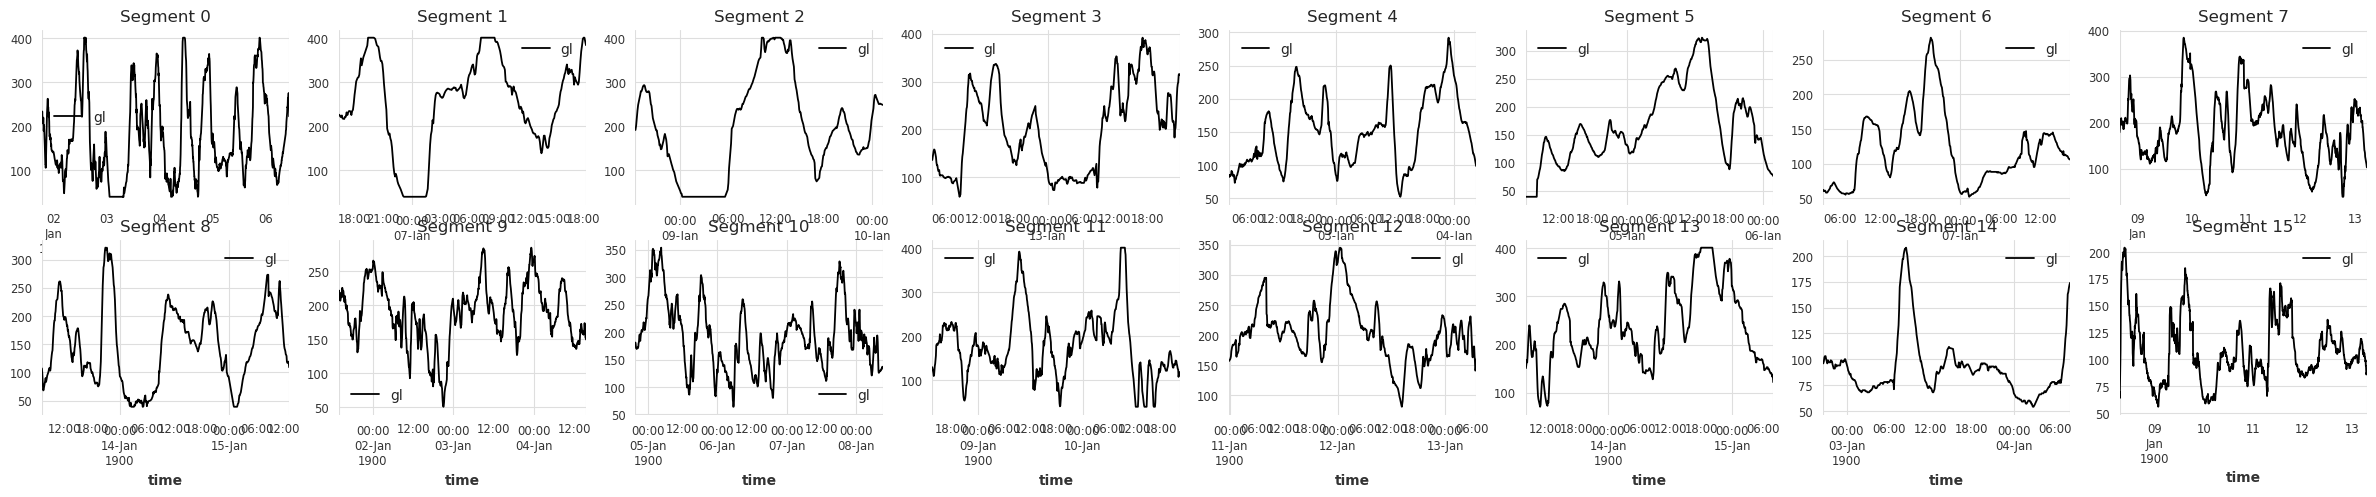

In [ ]:
# print min, max, median, mean, std of segment lengths
segment_lens = []
for group, data in formatter.train_data.groupby('id_segment'):
    segment_lens.append(len(data))
print('Train segment lengths:')
print('\tMin: ', min(segment_lens))
print('\tMax: ', max(segment_lens))
print('\t1st Quartile: ', np.quantile(segment_lens, 0.25))
print('\tMedian: ', np.median(segment_lens))
print('\tMean: ', np.mean(segment_lens))
print('\tStd: ', np.std(segment_lens))

# plot first 16 segments
num_segments = len(formatter.train_data['id_segment'].unique()[0:16])
plot_data = formatter.train_data.loc[formatter.train_data['id_segment'].isin(formatter.train_data['id_segment'].unique()[0:16])]

fig, axs = plt.subplots(2, num_segments//2, figsize=(30, 5))
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    if i <= 7:
        data.plot(x='time', y='gl', ax=axs[0,i], title='Segment {}'.format(group))
    else:
        data.plot(x='time', y='gl', ax=axs[1,i-8], title='Segment {}'.format(group))

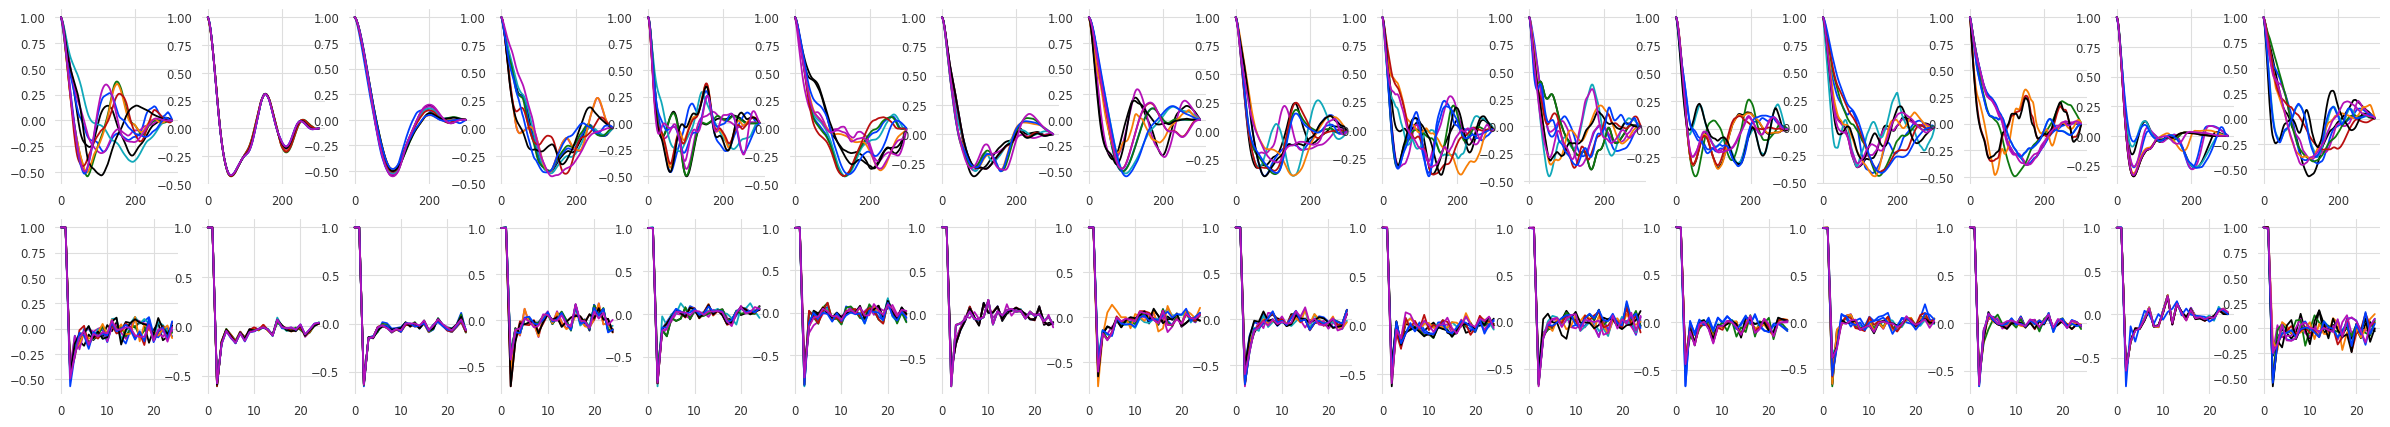

In [ ]:
# plot acf of random samples from first 16 segments
fig, ax = plt.subplots(2, num_segments, figsize=(30, 5))
lags = 300
for i, (group, data) in enumerate(plot_data.groupby('id_segment')):
    data = data['gl']
    if len(data) < lags:
        print('Segment {} is too short'.format(group))
        continue
    # select 10 random samples from index of data
    sample = np.random.choice(range(len(data))[:-lags], 10, replace=False)
    # plot acf / pacf of each sample
    for j in sample:
        acf, acf_ci = sm.tsa.stattools.acf(data[j:j+lags], nlags=lags, alpha=0.05)
        pacf, pacf_ci = sm.tsa.stattools.pacf(data[j:j+lags], method='ols-adjusted', alpha=0.05)
        ax[0, i].plot(acf)
        ax[1, i].plot(pacf)

It is very hard to name the proper parameters for ARIMA model based on current ACF and PACF plots since within each segment, samples are behaving very differently showing different structures suitable for ARIMA model. However, we can still spot some common traits between segments. First, the autocorrelation graphs decays exponentially for almost every segment, on average, up to 20-50 lags (in some cases up to 100). Hence, the Auto Regression (AR) parameter can be set around these numbers. The partial autocorrelation plots pick around 2 for the first time and become close to zero after 5 lags at max. So, the Moving Average (MA) parameter can be set at 2. 

# Change the config according to the observations above

In [3]:
with open('./config/weinstock.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
# set interpolation params for no interpolation
config['interpolation_params']['gap_threshold'] = 45
config['interpolation_params']['min_drop_length'] = 240
# set split params for no splitting
config['split_params']['test_percent_subjects'] = 0.1
config['split_params']['length_segment'] = 240
# set scaling params for no scaling
config['scaling_params']['scaler'] = 'None'

formatter = DataFormatter(config)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		time_year: REAL_VALUED (KNOWN_INPUT)
		time_month: REAL_VALUED (KNOWN_INPUT)
		time_day: REAL_VALUED (KNOWN_INPUT)
		time_hour: REAL_VALUED (KNOWN_INPUT)
		time_minute: REAL_VALUED (KNOWN_INPUT)
Interpolating data...
	Dropped segments: 12198
	Extracted segments: 757
Splitting data...
	Train: 332925 (67.33%)
	Val: 98640 (19.95%)
	Test: 122437 (24.76%)
Scaling data...
	No scaling applied
Data formatting complete.
--------------------------------


# Models

## Convert data and (optional) scaling

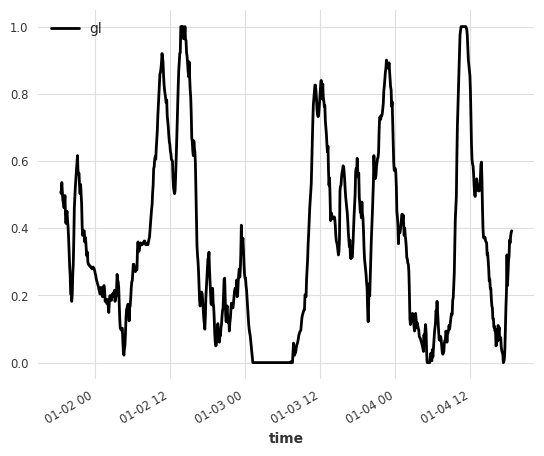

In [4]:
# get columns
time_col = formatter.get_column('time')
group_col = formatter.get_column('sid')
target_col = formatter.get_column('target')
static_cols = formatter.get_column('static_covs')
static_cols = static_cols + [formatter.get_column('id')] if static_cols is not None else [formatter.get_column('id')]
dynamic_cols = formatter.get_column('dynamic_covs')
future_cols = formatter.get_column('future_covs')

# build series
series, scalers = make_series({'train': formatter.train_data,
                                'val': formatter.val_data,
                                'test': formatter.test_data},
                                time_col,
                                group_col,
                                {'target': target_col,
                                'static': static_cols,
                                'dynamic': dynamic_cols,
                                'future': future_cols})

series['train']['target'][0].plot()

## ARIMA

In [9]:
# supress warnings
warnings.filterwarnings('ignore')
arima = models.ARIMA(p=1, d=1, q=1, seasonal_order=(0, 0, 0, 0))
forecasts = arima.backtest(series['val']['target'],
                           train_length=156,
                           forecast_horizon=12,
                           stride=12,
                           retrain=True,
                           metric=[metrics.rmse, 
                                    metrics.mae,],
                           last_points_only=False,
                           verbose=True)

  0%|          | 0/411 [00:00<?, ?it/s]

/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeliho

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

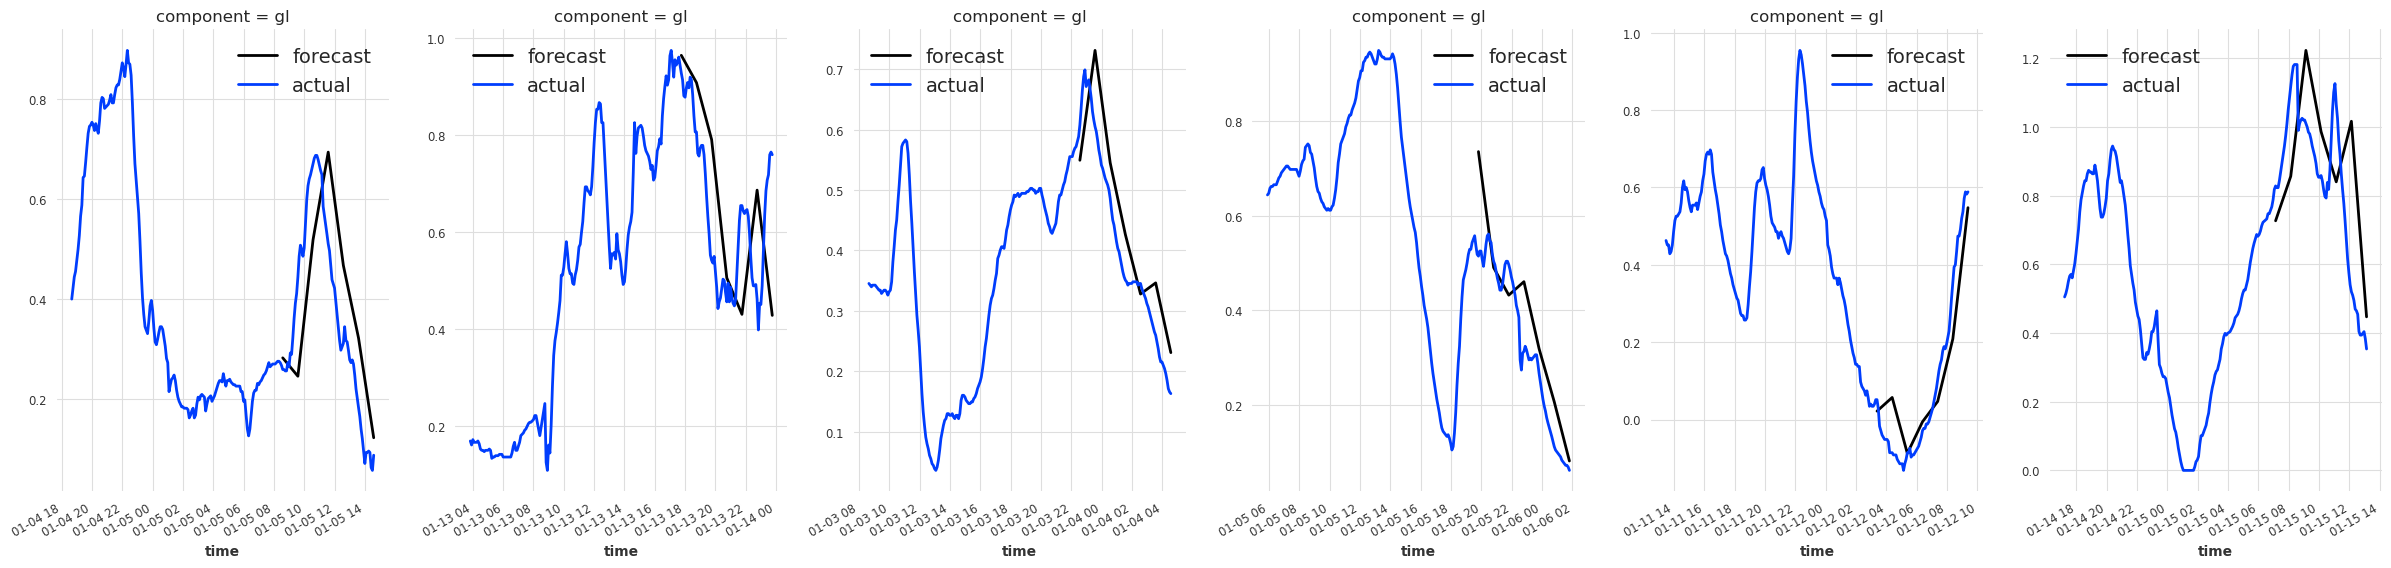

In [6]:
fig, axs = plt.subplots(1, 6, figsize=(30, 6))
for i in range(6):
    forecasts[i].plot(label='forecast', ax=axs[i])
    series['val']['target'][i].plot(label='actual', ax=axs[i])
    axs[i].legend(fontsize=14)